In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.00918994518478555 0.032159415587346474; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863967 -0.10696223889695364], [-0.0037362031674817928 0.011184638740456908 … -0.07094318488635357 -0.050323491624458885; 0.01979088919057409 0.030620168627788776 … 0.030785185388674228 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.137359927485125 0.03213684839745746; 0.042094688716242876 -0.10110240825174423 … -0.06636174473552493 -0.08508079724902803], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

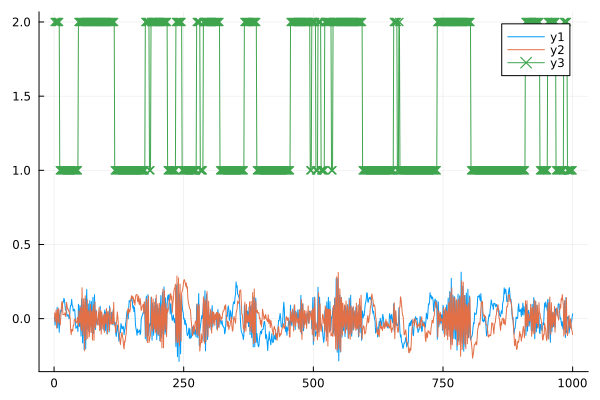

In [4]:
plot(x')
plot!(z, marker=:x)

In [5]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.001 * I(p))

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([-1.26568024925137 -0.9976332962608697; 1.4083219913311036 -0.33858277830853944; … ; 0.11964081053499176 1.0222783516680272; 0.6740889070887084 2.1655506694970224], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.4554542

In [6]:
#FB = StateSpaceDynamics.initialize_forward_backward(modeli, T)
#FS = [StateSpaceDynamics.initialize_FilterSmooth(modeli.B[k], T) for k in 1:K]

#ml = zeros(100,1)
#for i in 1:length(ml)
#    ml[i] = variational_expectation!(modeli, y, FB, FS)  
#end

In [7]:
#plot(ml)

In [8]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=2)

([-89482.32098336998, -11881.472418696158], [11.896847812366653, 8.133526016670286], StateSpaceDynamics.ForwardBackward{Float64}([-8.16889006682271 -10.091473034254381 … -13.31681552651742 -15.600051800353642; -26.669394065596407 -20.759062271635713 … -17.167239677825524 -19.75336601763277], [-8.291438595012947 -18.488272144656484 … -11865.76932538747 -11881.474196012166; -28.829290831024537 -31.353085950011362 … -11871.785791387763 -11887.805958135197], [-11873.18098010167 -11862.984147127176 … -15.703668031906894 0.0; -11874.685037359044 -11864.487503065739 … -17.14853665073453 0.0], [-2.673914423212409e-10 -5.754172889282927e-7 … -0.0005747232171415817 -0.0017773160088836448; -22.041909493653293 -14.368170319336059 … -7.461909342338913 -6.333539439039669], [-5.756846803706139e-7 -14.36817032896397; -22.041930208471967 -32.82658102329515;;; -2.1196159650571644e-5 -10.789223982032127; -14.368912398291286 -21.574596245705834;;; -0.00013318831770448014 -9.092037431806602; -10.7932477381

In [9]:
k = 2
StateSpaceDynamics.Q_obs(modeli.B[k].obs_model.C, modeli.B[k].obs_model.R,
    FS[k].E_z[:,:,1], FS[k].E_zz[:,:,:,1],y)

-64510.94901012014

In [10]:
StateSpaceDynamics.Q_obs_new(modeli.B[k].obs_model.C, modeli.B[k].obs_model.R,
    FS[k].E_z[:,:,1], FS[k].E_zz[:,:,:,1],y)

-64510.94901012012

In [13]:
StateSpaceDynamics.variational_qs!([modeli.B[k].obs_model], FB, y, [FS[k]])

In [19]:
obs_dim = size(modeli.B[k].obs_model.C, 1)
T_step = size(FS[k].E_z, 2)
R_chol = cholesky(Symmetric(modeli.B[k].obs_model.R))
log_det_R = logdet(R_chol)
const_term = obs_dim * log(2π)
-0.5 * (T_step * (const_term + log_det_R)) + sum(FB.loglikelihoods, dims=2)[1]

-64510.94901012021

In [11]:
modeli.A

2×2 Matrix{Float64}:
 0.928115  0.0718846
 0.208733  0.791267

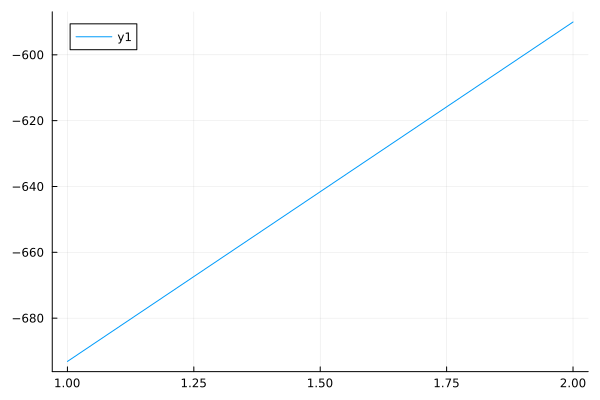

In [12]:
plot(mls)

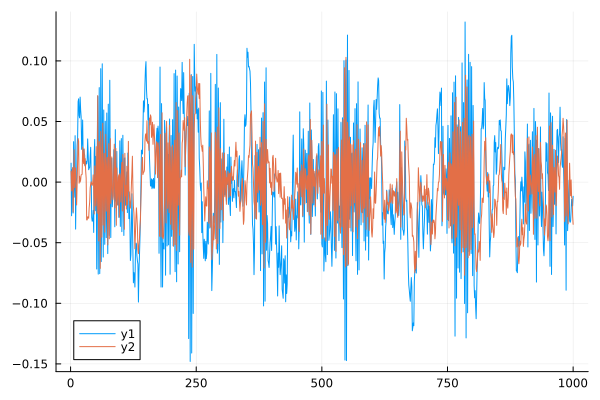

In [13]:
plot(FS[1].x_smooth')

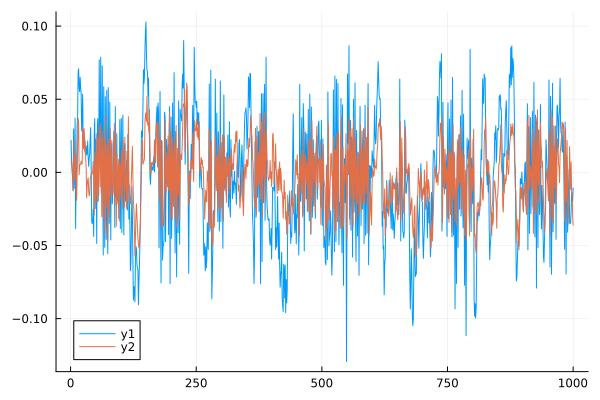

In [14]:
plot(FS[2].x_smooth')

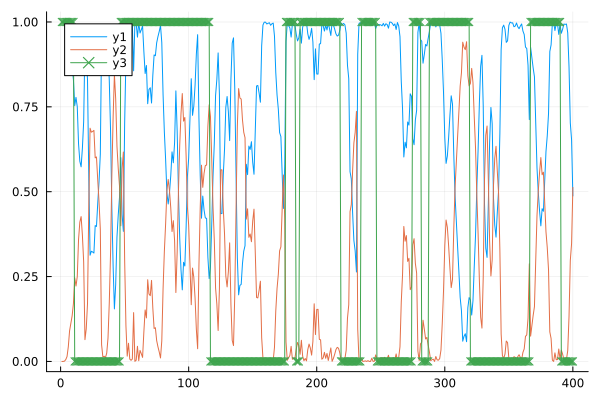

In [15]:
plot(exp.(FB.γ[:,1:400])')
plot!(z[1:400] .- 1, marker=:x)

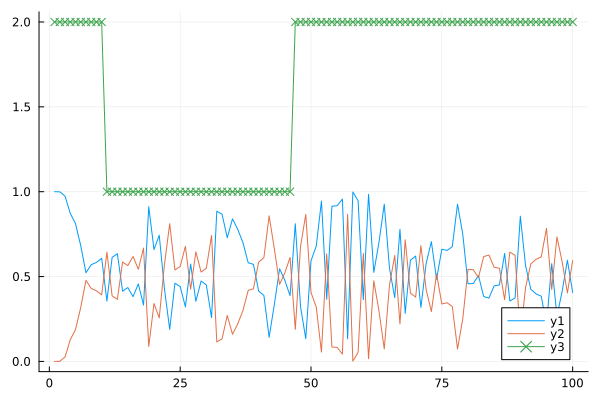

In [16]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

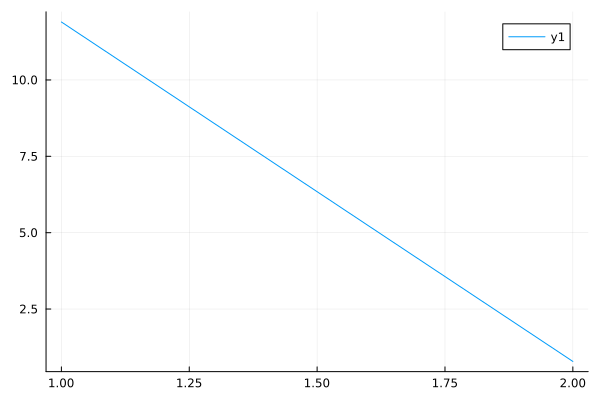

In [17]:
plot(param_diff)